In [1]:
from IPython.display import Image

- PG (policy gradient) vs. REINFORCE
- baseline
- Advantange Actor-Critic（A2C）
- 参考
    - https://spinningup.openai.com/en/latest/spinningup/rl_intro.html

- 策略的熵：

$$
\mathcal H(\pi(\cdot|s_t))=-\sum_{a_t}\pi(a_t|s_t)\log(\pi(a_t|s_t))=\mathbb E_{a_t\sim \pi}[-\log\pi(a_t|s_t)]
$$

## Bellman equations

for $V(s)$

$$
V(s)=R(s)+\gamma \sum_{s'}P(s'|s,a)V(s')
$$

for $Q(s,a)$

$$
Q(s,a)=R(s)+\gamma \sum_{s'}P(s'|s,a)\max_{a'}Q(s',a')
$$

## PG (Policy Gradient)


> Approximate policy function $\pi(a|s_t)$ by policy network $\pi_\theta(a|s_t)$.\
> Approximate value function $V_\pi(s_t)$ by:
$$V_\theta(s_t)=\sum_a\pi_\theta(a|s_t)Q_\pi(s_t,a)$$

- $\pi_\theta(a|s)$: policy network to approximate policy function $\pi(a|s_t)$
    - $\sum_{a\in \mathcal A}\pi_\theta(a|s)=1$
- Reward & Return
    - discounted **Return**
        - 有的地方也把 $U_t$ 记作 $G_t$
        - 如何理解 Returns（cumulative future **reward**） 与 Rewards

    $$
    \begin{split}
    &U_t=R_t+\gamma R_{t+1} + \gamma^2 R_{t+2} + \gamma^3 R_{t+3}+\cdots\\
    &U_t=R_t+\gamma U_{t+1}
    \end{split}
    $$

    - $U_t$ 是一个随机变量，如果一轮游戏我们得到（observe）一次完整的 trajectory，
        - 我们观测到 $r_t, r_{t+1},r_{t+2},\cdots,r_n$（$R_t$ 是随机变量，$r_t$ 是对其的观测）
            - rewards $R_t$ 是随机的，自然return $U_t$ 也是随机的
            - $R_t$ 依赖 $S_t$ 和 $A_t$
                - $S_t\sim P(\cdot|s_{t-1}, a_{t-1})$
                - $A_t\sim \pi(\cdot|s_t)$
        - 因此可以计算 $t$ 时刻的 discounted return：$u_t=r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+\cdots+\gamma^{n-t}r_{n}$
- Action-Value function $Q_\pi(s, a)$
    - discounted return: $U_t=R_t+\gamma U_{t+1}=R_t+\gamma R_{t+1}+\gamma^2 R_{t+2}+\cdots +\gamma^{n-t}R_n$
    - $Q_\pi(s_t,a_t)=\mathbb E[U_t|S_t=s_t,A_t=a_t]$ （$Q_\pi(s,a)=\mathbb E[U_t|S_t=s,A_t=a]$）
        - 为什么叫 action-value function，Given policy $\pi(a|s)$, $Q_\pi(s,a)$ evaluates how good it is for an agent to pick  action $a$ while being in state $s$.
        - 也就是随机变量 $U_t$ 依赖随机变量 states $S_t,S_{t+1},\cdots,S_n$ 以及随机变量 actions $A_t,A_{t+1},\cdots,A_n$
        - $s_t, a_t$ 则是观测值；
        - $S_{t+1}\sim p(\cdot|s_t,a_t), \cdots, S_n\sim p(\cdot|s_{n-1},a_{n-1})$
        - $A_{t+1}\sim \pi(\cdot|s_{t+1}), \cdots, A_n\sim \pi(\cdot|s_n)$
        - $Q_\pi(s_t,a_t)$ 依赖于 $s_t,a_t,\pi(a_t|s_t),p(s_{t+1}|s_t,a_t)$（虽然有时候写作 $Q(s_t,a_t)$，其实在计算上依赖 $\pi(\cdot|), p(\cdot|)$）
- State-Value function: $V_\pi(s_t)$
    - $V_\pi(s_t)=\mathbb E_A[Q_\pi(s_t,A)]=\mathbb E_{A\sim \pi(\cdot|s_t)}[Q_\pi(s_t,A)]=\sum_{a\in A} \pi(a|s_t)Q_\pi(s_t,a)$，
        - 对所有的动作进行积分；
    - 实际意义，对于 fixed policy, $V_\pi(s)$ evaluates how good the situation is in state $s$.
    - $\mathbb E_S[V_\pi(S)]$ evaluates how good the policy $\pi$ is.

In [3]:
Image(url='./imgs/s_a_r_pi.png', width=400)

In [2]:
Image(url='./imgs/s_a_r_p.png', width=400)

approximate state-value function

$$
V_\theta(s)=\sum_a\pi_\theta(a|s)Q_\pi(s,a)
$$

policy-based learning, $J(\theta)=\mathbb E_S(V_\theta(S))$（把所有的状态积掉）

$$
\theta\leftarrow \theta+\beta\underbrace{\frac{\partial V_\theta(s)}{\partial \theta}}_{\text{policy gradient}}
$$

In [4]:
Image(url='./imgs/pg_gradient.png', width=400)

In [8]:
Image(url='https://i0.wp.com/roboticseabass.com/wp-content/uploads/2020/08/policy_gradient_types.png?w=822&ssl=1', width=400)

### DQN

- optimal action-value function

    $$
    \begin{split}
    Q^\star(s_t,a_t)&=\max_\pi Q_\pi(s_t,a_t)\\
    &=\max_\pi\mathbb E[U_t|S_t=s_t,A_t=a_t]
    \end{split}
    $$

  - DQN 要做的事情，逼近 $Q_\theta(s_t,a_t)=Q^\star(s_t,a_t)$
  - 然后 $a_t=\arg\max_{a} Q_\theta(s_t,a_t)$

### TD (temporal difference)

- prediction(estimate) vs. actual (groudtruth, label)
    - $L=\frac12(q-y)^2$ ($q=Q(\textbf w)$)
    - gradient: $\frac{\partial L}{\partial w}=\frac{\partial L}{\partial q}\frac{\partial q}{\partial w}=(q-y)\frac{\partial Q(w)}{\partial w}$
    - gradient descent: $w_{t+1}=w_t-\alpha\cdot\frac{\partial L}{\partial w}\big|_{w=w_t}$
- Can I update the model before finishing the trip?，如下图
    - model's estimate: $Q(\textbf w)$=1000
    - **updated estimate**: $300+600=900$ (TD target)
        - TD target $y=900$ is more reliable estimate than 1000（因此引入了更多的真实数据）
        - TD error: $1000-900=100$
        - 关于 td error，也可以从 (400-300=100)的角度（prediction & ground truth）来理解

$$
L=\frac12\left(\underbrace{Q(\textbf w)-\underbrace y_{\text{td target}}}_{\text{td error}}\right)^2
$$

In [5]:
Image(url='./imgs/td_trip.png', width=200)

## TD learning & DQN

$$
\underbrace{T_{NYC\rightarrow Atl}}_{\text{model's estimate}}\approx \underbrace{T_{NYC\rightarrow DC}}_{\text{actual time}} + \underbrace{T_{DC\rightarrow NYC}}_{\text{model's estimate}}
$$

- 此处我们可以类比 rl （DQN）

    $$
    \begin{split}
    &Q(s_t,a_t;\textbf w)\approx \underbrace{r_t }_{\text{immediate reward}}+ \underbrace{\gamma\cdot Q(s_{t+1},a_{t+1};\textbf w)}_{\text{discounted future reward}}\\
    &U_t=R_t+\gamma U_{t+1}
    \end{split}
    $$
  
    - $U_t$: discounted return
    - DQN's output: $Q(s_t,a_t;\textbf w)$ 就是对 $U_t$ 的估计（estimate）
    - DQN's output: $Q(s_{t+1},a_{t+1};\textbf w)$ 就是对 $U_{t+1}$ 的估计（estimate）
 
    $$
    \begin{split}
    &\underbrace{Q(s_t,a_t;\textbf w)}_{\text{estimate of }U_t}\approx \mathbf E[R_t + \gamma\underbrace {Q(S_{t+1},A_{t+1};\textbf w)}_{\text{estimate of } U_{t+1}}]\\
    &\underbrace{Q(s_t,a_t;\textbf w)}_{\text{Prediction}}\approx \underbrace{r_t + \gamma{Q(s_{t+1},a_{t+1};\textbf w)}}_{\text{TD target}}
    \end{split}
    $$

- Prediction: $Q(s_t,a_t;\textbf w_t)$
- TD target:

$$
\begin{split}
&y_t=r_t+\gamma Q(s_{t+1},a_{t+1};\textbf w)\\
&y_t=r_t+\gamma \max_a Q(s_{t+1},a;\textbf w)
\end{split}
$$

## PG with baseline

- $\pi_\theta(a|s)$ policy network for controlling the agent
- state-value function

$$
\begin{split}
V_\pi(s)&=\mathbb E_{A\sim \pi}[Q_\pi(s, A)]\\
&=\sum_a \pi_\theta(a|s)Q_\pi(s,a)
\end{split}
$$

- PG

$$
\frac{\partial V_\pi(s)}{\partial \theta}=\mathbb E_{A\sim \pi}\left[\frac{\partial \ln \pi_\theta(A|s)}{\partial \theta}Q_\pi(s,A)\right]
$$

- PG with baseline
    - b (baseline) independent of $A_t$
    $$
    \frac{\partial V_\pi(s_t)}{\partial \theta}=\mathbb E_{{A_t}\sim \pi}\underbrace{\left[\frac{\partial \ln \pi_\theta(A_t|s_t)}{\partial \theta}\left(Q_\pi(s_t,A_t)-b\right)\right]}_{g(A_t)}
    $$
    - randomly sample (Monte Carlo Approximation) $a_t\sim \pi_\theta(\cdot|s_t)$ 计算 $g(a_t)$
    - $E_{A_t\sim \pi}[g(A_t)]=\frac{\partial V_\pi(s_t)}{\partial \theta}$
    - spg(stochastic policy gradient): $g(a_t)=\frac{\partial \pi_\theta(a_t|s)}{\partial \theta}\left(Q_\pi(s_t,a_t)-b\right)$
    - $\theta\leftarrow \theta+\eta g(a_t)$
- choices of $b$
    - state-value function: $V_\pi(s_t)$ (which is close $Q_\pi(s_t,a_t)$)
        - $V_\pi(s_t)=E_{A_t}(Q_\pi(s_t,A_t))$
$$
\frac{\partial V_\pi(s_t)}{\partial \theta}=\mathbb E_{{A_t}\sim \pi}\underbrace{\left[\frac{\partial \ln \pi_\theta(A_t|s_t)}{\partial \theta}\left(Q_\pi(s_t,A_t)-V_\pi(s_t)\right)\right]}_{g(A_t)}
$$

## REINFORCE with Baseline

- discounted return
    
    $$
    U_t=r_t+\gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 r_{t+3} + \cdots=\sum_{i=t}^n\gamma^{i-t}r_i
    $$
- action-value function

$$
Q_\pi(s_t,a_t)=\mathbb E[U_t|s_t,a_t]
$$

- state-value function

$$
V_\pi(s_t)=\mathbb E_A[Q_\pi(s_t,A)|s_t]
$$

- PG with baseline

    $$
    \frac{\partial V_\pi(s_t)}{\partial \theta}=\mathbb E_{{A_t}\sim \pi}\underbrace{\left[\frac{\partial \ln \pi_\theta(A_t|s_t)}{\partial \theta}\left(Q_\pi(s_t,A_t)-V_\pi(s_t)\right)\right]}_{g(A_t)}
    $$

  - randomly sample $a_t\sim \pi_\theta(\cdot|s_t)$
  - Monte Carlo Approximation to $Q_\pi(s_t,a_t)\approx u_t$ (REINFORCE)
      - Observing/collecting the trajectory: $(s_t,a_t,r_t), (s_{t+1},a_{t+1},r_{t+1}), \cdots, (s_n,a_n,r_n)$
      - compute return: $u_t=\sum_{i=t}^n\gamma^{t-i}r_{i}$
      - $Q_\pi(s_t,a_t)\approx u_t$
        $$
        \frac{\partial V_\pi(s_t)}{\partial \theta}\approx g(a_t)\approx \frac{\partial \ln\pi_\theta(a_t|s_t)}{\partial \theta}\underbrace{\left({u_t-v_w(s_t)}\right)}_{-\delta_t}
        $$

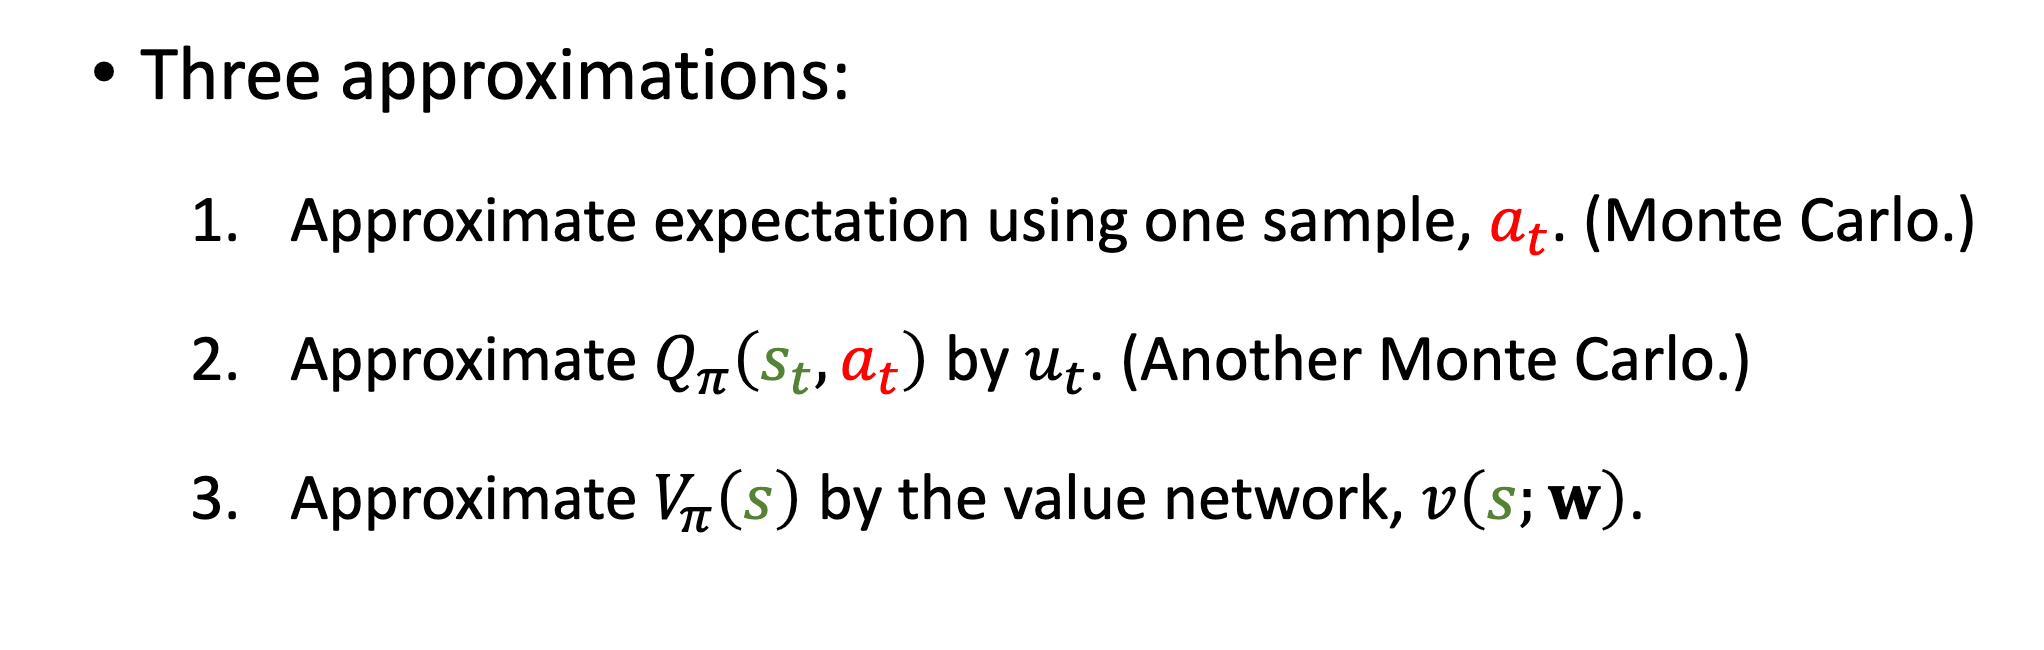

In [6]:
Image('./imgs/reinforce_monte_carlo.png', width=400)

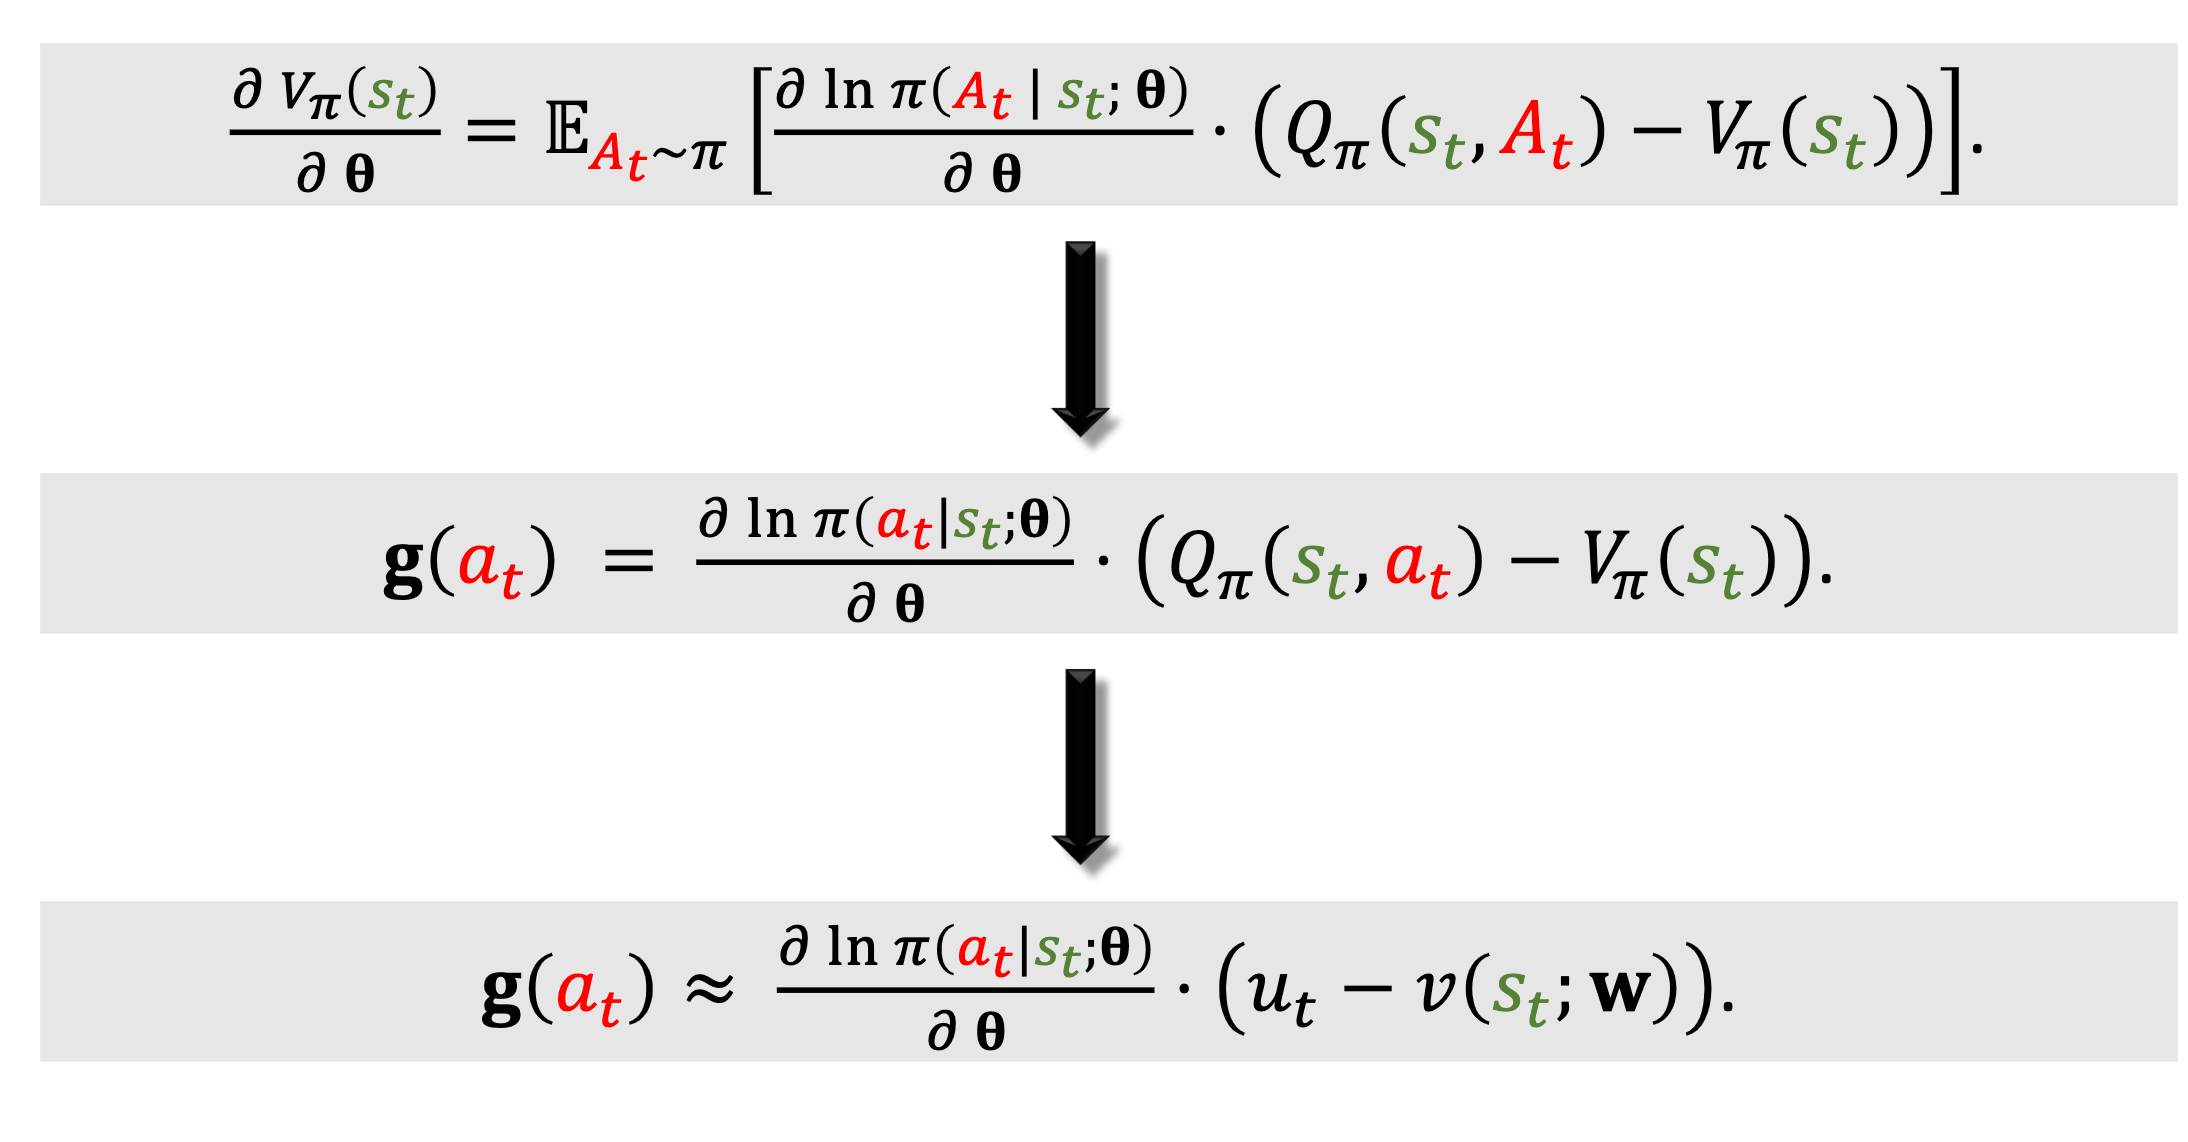

In [7]:
Image('./imgs/reinforce_with_baseline_approx.png', width=400)

### Deep Learning (A2C)

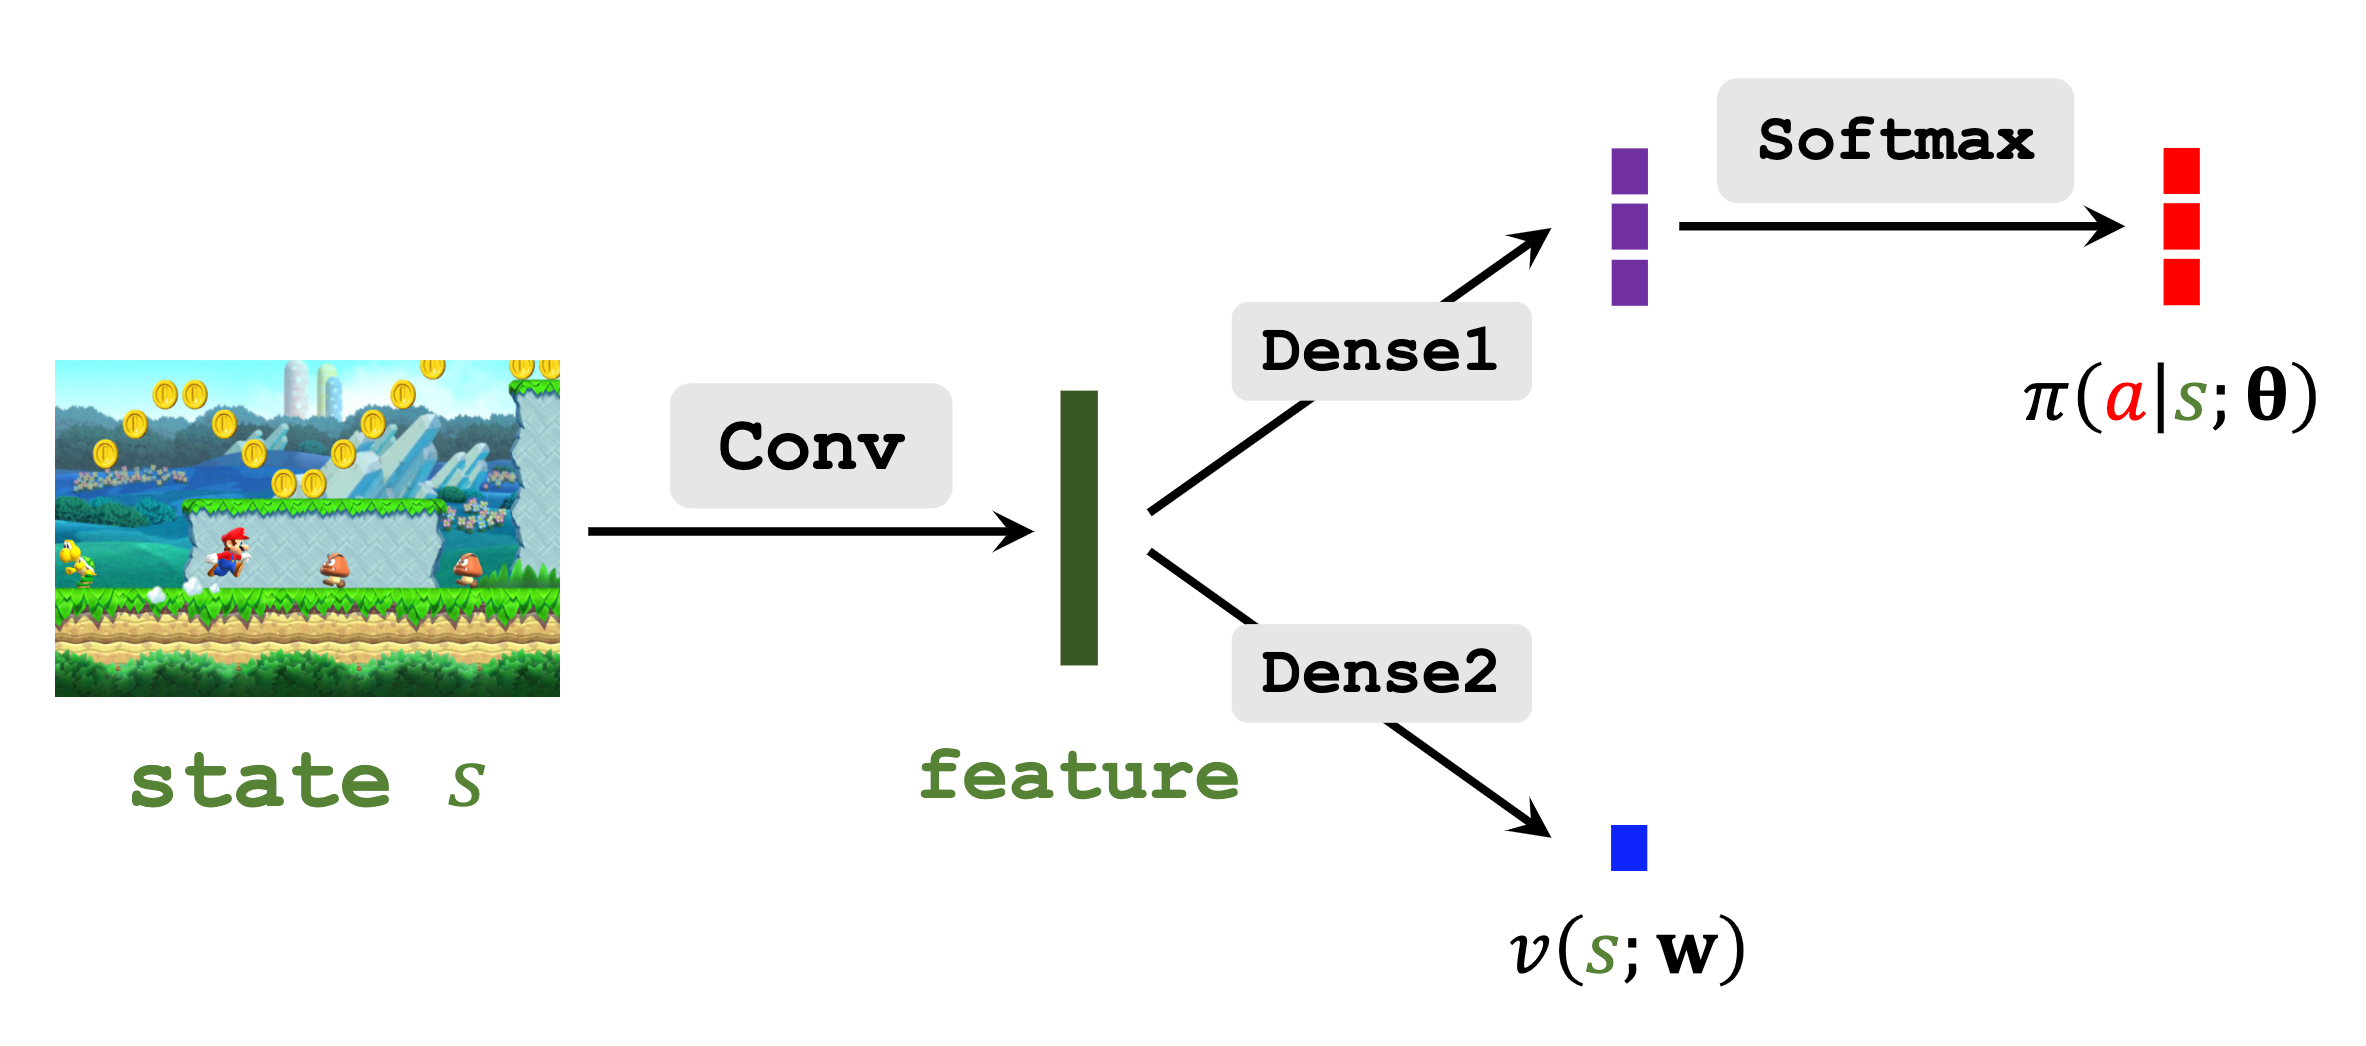

In [8]:
Image('./imgs/policy_net_value_net_sharing.png', width=500)

In [9]:
Image(url='./imgs/value_net_update.png', width=400)

In [10]:
Image(url='./imgs/policy_value_update_summary.png', width=400)